<a href="https://colab.research.google.com/github/dvschultz/ShapeMatchingGAN/blob/master/ShapeMatchingGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Shape Matching GAN

# Install Library and required data

In [1]:
!git clone https://github.com/dvschultz/ShapeMatchingGAN
%cd ShapeMatchingGAN/save
!gdown --id 1gjHR39deUSPChtRbKAD80waoQFTiXyMs #download example checkpoint files
!unzip ShapeMGAN-data_plus_model.zip
!rm -r data/style
!mkdir ../data/rawtext/yaheiB/train
!mv data/rawtext/yaheiB/train/*.* ../data/rawtext/yaheiB/train/
!mkdir ../data/rawtext/augment
!mv data/rawtext/augment/*.* ../data/rawtext/augment/
!mv save/*.* ./
!rmdir save
!rm ShapeMGAN-data_plus_model.zip
!rm -r data
%cd ../src

Cloning into 'ShapeMatchingGAN'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 615 (delta 10), reused 2 (delta 0), pack-reused 592
Receiving objects: 100% (615/615), 6.23 MiB | 4.28 MiB/s, done.
Resolving deltas: 100% (291/291), done.
/content/ShapeMatchingGAN/save
Downloading...
From: https://drive.google.com/uc?id=1gjHR39deUSPChtRbKAD80waoQFTiXyMs
To: /content/ShapeMatchingGAN/save/ShapeMGAN-data_plus_model.zip
118MB [00:00, 192MB/s]
Archive:  ShapeMGAN-data_plus_model.zip
   creating: data/
   creating: data/rawtext/
   creating: data/rawtext/augment/
  inflating: data/rawtext/augment/0000.png  
  inflating: data/rawtext/augment/0001.png  
  inflating: data/rawtext/augment/0002.png  
  inflating: data/rawtext/augment/0003.png  
  inflating: data/rawtext/augment/0004.png  
   creating: data/rawtext/yaheiB/
   creating: data/rawtext/yaheiB/train/
  inflating: data/rawtext/yaheiB/tra

# Test
Let’s run a sample test to see how it does. This will generate a file named 'output.png' in your `/output/` folder.

In [9]:
!python test.py --scale 0.0 --structure_model ../save/fire-GS-iccv.ckpt --texture_model ../save/fire-GT-iccv.ckpt --gpu

--- load options ---
gpu: True
name: output
result_dir: ../output/
scale: 0.0
scale_step: 0.2
structure_model: ../save/fire-GS-iccv.ckpt
text_name: ../data/rawtext/yaheiB/val/0801.png
text_type: 0
texture_model: ../save/fire-GT-iccv.ckpt
--- load data ---
--- load model ---
--- testing ---
--- save ---


Another example with some additional arguments. This will generate multiple images at different “scales.”

In [13]:
!python test.py --text_name ../data/rawtext/yaheiB/val/0801.png --scale -1 --scale_step 0.005 --structure_model ../save/fire-GS-iccv.ckpt --texture_model ../save/fire-GT-iccv.ckpt --result_dir ../output --name fire-0801-3 --gpu

--- load options ---
gpu: True
name: fire-0801-3
result_dir: ../output
scale: -1.0
scale_step: 0.005
structure_model: ../save/fire-GS-iccv.ckpt
text_name: ../data/rawtext/yaheiB/val/0801.png
text_type: 0
texture_model: ../save/fire-GT-iccv.ckpt
--- load data ---
--- load model ---
--- testing ---
--- save ---


In [14]:
!zip fire_images.zip /content/ShapeMatchingGAN/output/fire-0801-3_*.png

  adding: content/ShapeMatchingGAN/output/fire-0801-3_0.png (deflated 6%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_100.png (deflated 5%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_101.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_102.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_103.png (deflated 5%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_104.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_105.png (deflated 5%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_106.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_107.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_108.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_109.png (deflated 4%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_10.png (deflated 6%)
  adding: content/ShapeMatchingGAN/output/fire-0801-3_110.png (deflated 4%)
  adding: conte

# Train

## Train the Sketch Module


In [2]:
# !python trainSketchModule.py --help
!python trainSketchModule.py --text_path ../data/rawtext/yaheiB/train --text_datasize 708 --augment_text_path ../data/rawtext/augment --augment_text_datasize 5 --batchsize 16 --Btraining_num 12800 --save_GB_name ../save/GB.ckpt --gpu

--- load options ---
Btraining_num: 12800
DB_nf: 32
DB_nlayers: 5
GB_nf: 32
GB_nlayers: 6
augment_text_datasize: 5
augment_text_path: ../data/rawtext/augment
batchsize: 16
epochs: 3
gpu: True
save_GB_name: ../save/GB.ckpt
text_datasize: 708
text_path: ../data/rawtext/yaheiB/train
--- create model ---
--- training ---
Epoch [1/3][001/800]: LDadv: +0.017, LGadv: +0.152, Lrec: +81.663
Epoch [1/3][002/800]: LDadv: +0.061, LGadv: +0.158, Lrec: +63.030
Epoch [1/3][003/800]: LDadv: +0.086, LGadv: +0.158, Lrec: +49.606
Epoch [1/3][004/800]: LDadv: +0.069, LGadv: +0.152, Lrec: +36.851
Epoch [1/3][005/800]: LDadv: +0.078, LGadv: +0.175, Lrec: +26.935
Epoch [1/3][006/800]: LDadv: +0.057, LGadv: +0.174, Lrec: +22.889
Epoch [1/3][007/800]: LDadv: +0.049, LGadv: +0.147, Lrec: +18.177
Epoch [1/3][008/800]: LDadv: +0.037, LGadv: +0.146, Lrec: +17.177
Epoch [1/3][009/800]: LDadv: +0.022, LGadv: +0.173, Lrec: +15.270
Epoch [1/3][010/800]: LDadv: +0.025, LGadv: +0.158, Lrec: +13.684
Epoch [1/3][011/800]:

## Train the Structure Transfer model


In [0]:
!python trainStructureTransfer.py --style_name ../data/style/ladiescrop-720.png --batchsize 16 --Straining_num 2560 --step1_epochs 30 --step2_epochs 40 --step3_epochs 80 --scale_num 4 --Sanglejitter --save_path ../save --save_name ladiescrop --gpu

--- load options ---
DB_nf: 32
DB_nlayers: 5
DS_nf: 32
DS_nlayers: 4
DT_nf: 32
DT_nlayers: 4
GB_nf: 32
GB_nlayers: 6
GS_nf: 32
GS_nlayers: 6
GT_nf: 32
GT_nlayers: 6
Sanglejitter: True
Straining_num: 2560
Tanglejitter: False
Ttraining_num: 800
batchsize: 16
glyph_preserve: False
gpu: True
load_GB_name: ../save/GB-iccv.ckpt
load_GS_name: ../save/fire-GS.ckpt
save_name: ladiescrop
save_path: ../save
scale_num: 4
step1_epochs: 30
step2_epochs: 40
step3_epochs: 80
step4_epochs: 10
style_loss: False
style_name: ../data/style/ladiescrop-720.png
subimg_size: 256
text_datasize: 708
text_path: ../data/rawtext/yaheiB/train
texture_step1_epochs: 40
texture_step2_epochs: 10
--- create model ---
--- training ---
Step1, Epoch [01/30][001/160]: LDadv: +0.003, LGadv: +0.013, Lrec: +91.473, Lgly: +0.000
Step1, Epoch [01/30][002/160]: LDadv: +0.010, LGadv: +0.013, Lrec: +78.175, Lgly: +0.000
Step1, Epoch [01/30][003/160]: LDadv: +0.018, LGadv: +0.013, Lrec: +65.360, Lgly: +0.000
Step1, Epoch [01/30][004/

## Train the Texture Transfer

In [2]:
!python trainTextureTransfer.py --style_name ../data/style/fire.png --batchsize 4 --Ttraining_num 800 --texture_step1_epochs 40 --Tanglejitter --save_path ../save --save_name fire --gpu

Streaming output truncated to the last 5000 lines.
Step1, Epoch [16/40][003/200]: LDadv: +10.136, LGadv: -6.040, Lrec: +10.789, Lsty: +0.000
Step1, Epoch [16/40][004/200]: LDadv: +10.619, LGadv: -5.565, Lrec: +13.058, Lsty: +0.000
Step1, Epoch [16/40][005/200]: LDadv: +9.487, LGadv: -6.429, Lrec: +10.545, Lsty: +0.000
Step1, Epoch [16/40][006/200]: LDadv: +14.016, LGadv: -6.976, Lrec: +18.230, Lsty: +0.000
Step1, Epoch [16/40][007/200]: LDadv: +13.047, LGadv: -11.251, Lrec: +17.857, Lsty: +0.000
Step1, Epoch [16/40][008/200]: LDadv: +11.376, LGadv: -10.803, Lrec: +13.171, Lsty: +0.000
Step1, Epoch [16/40][009/200]: LDadv: +9.835, LGadv: -9.684, Lrec: +11.390, Lsty: +0.000
Step1, Epoch [16/40][010/200]: LDadv: +11.126, LGadv: -11.943, Lrec: +14.802, Lsty: +0.000
Step1, Epoch [16/40][011/200]: LDadv: +8.086, LGadv: -12.477, Lrec: +10.011, Lsty: +0.000
Step1, Epoch [16/40][012/200]: LDadv: +12.544, LGadv: -6.886, Lrec: +19.201, Lsty: +0.000
Step1, Epoch [16/40][013/200]: LDadv: +10.221, L

# Try your own images

<PIL.Image.Image image mode=RGB size=768x1280 at 0x7F8AC82C7C88>


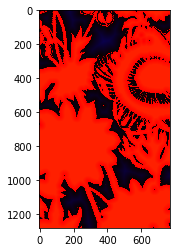

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import cv2
import scipy.ndimage as pyimg
import random
import os

import utils

# netShapeM.G_S.load_state_dict(torch.load('content/ShapeMatchingGAN/save/maple-GS-iccv.ckpt'))  
# netShapeM.eval()
I = utils.text_image_preprocessing('/content/uploads/ladiescrop.png')
print(I)
os.chdir('/content/outputs/')
cv2.imwrite('ladiescrop.png', cv2.cvtColor(np.array(I),cv2.COLOR_RGB2BGR))
plt.imshow(I)

In [4]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/dvschultz/ShapeMatchingGAN
   2f9e4c4..e1e5c5b  master     -> origin/master
Updating 2f9e4c4..e1e5c5b
Fast-forward
 src/trainTextureTransfer.py | 6 +++---
 1 file changed, 3 insertions(+), 3 deletions(-)
